이 노트북은 영화 리뷰(review) 텍스트를 긍정(positive) 또는 부정(negative)으로 분류합니다. 이 예제는 이진(binary)-또는 클래스(class)가 두 개인- 분류 문제입니다. 이진 분류는 머신러닝에서 중요하고 널리 사용됩니다.

이 튜토리얼에서는 텐서플로 허브(TensorFlow Hub)와 케라스(Keras)를 사용한 기초적인 전이 학습(transfer learning) 애플리케이션을 보여줍니다.

여기에서는 인터넷 영화 데이터베이스(Internet Movie Database)에서 수집한 50,000개의 영화 리뷰 텍스트를 담은 IMDB 데이터셋을 사용하겠습니다. 25,000개 리뷰는 훈련용으로, 25,000개는 테스트용으로 나뉘어져 있습니다. 훈련 세트와 테스트 세트의 클래스는 균형이 잡혀 있습니다. 즉 긍정적인 리뷰와 부정적인 리뷰의 개수가 동일합니다.

이 노트북은 텐서플로에서 모델을 만들고 훈련하기 위한 고수준 파이썬 API인 tf.keras와 전이 학습 라이브러리이자 플랫폼인 텐서플로 허브를 사용합니다. tf.keras를 사용한 고급 텍스트 분류 튜토리얼은 MLCC 텍스트 분류 가이드를 참고하세요.

In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.0.0


## IMDB 데이터셋 다운로드

In [14]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - ETA:  - ETA: 1: - ETA: 59s - ETA: 51 - ETA: 45 - ETA: 34 - ETA: 27 - ETA: 23 - ETA: 20 - ETA: 15 - ETA: 12 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 0us/step


매개변수 `num_words=10000`은 훈련 데이터에서 가장 많이 등장하는 상위 10,000개의 단어를 선택합니다. 데이터 크기를 적당하게 유지하기 위해 드물에 등장하는 단어는 제외하겠습니다.

## 데이터 탐색

In [15]:
print("훈련 샘플: {}, 레이블: {}".format(len(train_data), len(train_labels)))

훈련 샘플: 25000, 레이블: 25000


In [16]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [17]:
len(train_data[0]), len(train_data[1])

(218, 189)

## 정수를 단어로 다시 변환

In [18]:
# 단어와 정수 인덱스를 매핑한 딕셔너리
word_index = imdb.get_word_index()
word_index

1646592/1641221 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 0us/step


{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [19]:
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

In [20]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [22]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [23]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## 데이터 준비
리뷰-정수 배열은 신경망에 주입하기 전에 텐서로 변환해야 함. 변환 방법은 몇가지가 있음
* 원-핫 인코딩(one-hot encoding) : 정수 배열을 0과 1로 이루어진 벡터로 변환하는 방법. 배열 [3, 5]을 인덱스 3과 5만 1이고 나머지가 모두 0인 10000차원 벡터로 변환할 수 있음. 이 방법은 `num_words * num_reviews`크기의 행렬이 필요하기 때문에 메모리가 많이 필요함
* 다른 방법으로는, 정수 배열의 길이가 모두 같도록 패딩(padding)을 추가해 `max_length * num_reviews`크기의 정수 텐서를 만들어 사용. 이런 형태의 텐서를 다룰 수 있는 임베딩(embedding)층을 신경망의 첫 번째 층으로 사용할 수 있음

keras.preprocessing.sequence.pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.0)
* sequences : list나 lists, 해당 값들은 sequence
* maxlen : (Int)모든 sequences들의 max lenth
* padding : 'pre' 혹은 'post', sequence 앞 혹은 뒤에 pad값 입력
* value : padding 자리에 넣을 값, Float or String

In [24]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [25]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [26]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

뒤에 0이 채워진 것을 확인할 수 있음

## 모델 구성

In [27]:
# 입력 크기는 영화 리뷰 데이터셋에 적용된 어휘 사전의 크기입니다(10,000개의 단어)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16, input_shape=(None,)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


1. 첫 번째 층은 `Embedding`층으로 정수로 인코딩된 단어를 입력받아 각 인덱스에 해당하는 임베딩 벡터를 학습한다. 입력은 `(batch, sequence_length)`이며 최종 출력은 `(batch_size, sequence_length, output_dim)`형태이다. 
2. `GlobalAveragePooling1D`층은 `sequence`차원에 대한 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환. 

## 손실 함수 및 옵티마이저 설정
여기서는 긍정/부정 두 가지에 대한 분류 문제이고 확률을 출력하므로 `binary_crossentropy`손실 함수를 사용

In [29]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

## 검증 데이터셋 만들기
원본 데이터(train_data)에서 10000개의 샘플을 떼어내어 검증(validation set)을 만들어 사용

In [30]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## 모델 훈련

In [31]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - ETA: 25s - loss: 0.6930 - accuracy: 0.494 - ETA: 6s - loss: 0.6930 - accuracy: 0.491 - ETA: 3s - loss: 0.6930 - accuracy: 0.49 - ETA: 2s - loss: 0.6930 - accuracy: 0.50 - ETA: 1s - loss: 0.6929 - accuracy: 0.50 - ETA: 1s - loss: 0.6928 - accuracy: 0.50 - ETA: 0s - loss: 0.6927 - accuracy: 0.51 - ETA: 0s - loss: 0.6925 - accuracy: 0.52 - ETA: 0s - loss: 0.6924 - accuracy: 0.53 - ETA: 0s - loss: 0.6923 - accuracy: 0.54 - 2s 109us/sample - loss: 0.6922 - accuracy: 0.5499 - val_loss: 0.6903 - val_accuracy: 0.6519
Epoch 2/40
15000/15000 [==============================] - ETA: 0s - loss: 0.6900 - accuracy: 0.66 - ETA: 0s - loss: 0.6896 - accuracy: 0.67 - ETA: 0s - loss: 0.6893 - accuracy: 0.69 - ETA: 0s - loss: 0.6893 - accuracy: 0.68 - ETA: 0s - loss: 0.6889 - accuracy: 0.69 - ETA: 0s - loss: 0.6887 - accuracy: 0.69 - ETA: 0s - loss: 0.6883 - accuracy: 0.69 - ETA: 0s - loss: 0.6880 - 

15000/15000 [==============================] - ETA: 0s - loss: 0.3105 - accuracy: 0.89 - ETA: 0s - loss: 0.2975 - accuracy: 0.89 - ETA: 0s - loss: 0.2943 - accuracy: 0.89 - ETA: 0s - loss: 0.2914 - accuracy: 0.90 - ETA: 0s - loss: 0.2911 - accuracy: 0.90 - ETA: 0s - loss: 0.2903 - accuracy: 0.90 - ETA: 0s - loss: 0.2881 - accuracy: 0.90 - ETA: 0s - loss: 0.2880 - accuracy: 0.90 - ETA: 0s - loss: 0.2856 - accuracy: 0.90 - ETA: 0s - loss: 0.2847 - accuracy: 0.90 - 1s 45us/sample - loss: 0.2837 - accuracy: 0.9036 - val_loss: 0.3310 - val_accuracy: 0.8724
Epoch 16/40
15000/15000 [==============================] - ETA: 0s - loss: 0.2488 - accuracy: 0.91 - ETA: 0s - loss: 0.2642 - accuracy: 0.91 - ETA: 0s - loss: 0.2663 - accuracy: 0.90 - ETA: 0s - loss: 0.2678 - accuracy: 0.90 - ETA: 0s - loss: 0.2642 - accuracy: 0.90 - ETA: 0s - loss: 0.2688 - accuracy: 0.90 - ETA: 0s - loss: 0.2696 - accuracy: 0.90 - ETA: 0s - loss: 0.2692 - accuracy: 0.90 - ETA: 0s - loss: 0.2713 - accuracy: 0.90 - ETA: 

15000/15000 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.95 - ETA: 0s - loss: 0.1465 - accuracy: 0.95 - ETA: 0s - loss: 0.1508 - accuracy: 0.95 - ETA: 0s - loss: 0.1524 - accuracy: 0.95 - ETA: 0s - loss: 0.1484 - accuracy: 0.95 - ETA: 0s - loss: 0.1485 - accuracy: 0.95 - ETA: 0s - loss: 0.1479 - accuracy: 0.95 - ETA: 0s - loss: 0.1473 - accuracy: 0.95 - ETA: 0s - loss: 0.1461 - accuracy: 0.95 - ETA: 0s - loss: 0.1490 - accuracy: 0.95 - 1s 45us/sample - loss: 0.1492 - accuracy: 0.9541 - val_loss: 0.2865 - val_accuracy: 0.8869
Epoch 30/40
15000/15000 [==============================] - ETA: 0s - loss: 0.1665 - accuracy: 0.94 - ETA: 0s - loss: 0.1494 - accuracy: 0.95 - ETA: 0s - loss: 0.1421 - accuracy: 0.95 - ETA: 0s - loss: 0.1410 - accuracy: 0.95 - ETA: 0s - loss: 0.1452 - accuracy: 0.95 - ETA: 0s - loss: 0.1455 - accuracy: 0.95 - ETA: 0s - loss: 0.1450 - accuracy: 0.95 - ETA: 0s - loss: 0.1441 - accuracy: 0.95 - ETA: 0s - loss: 0.1459 - accuracy: 0.95 - ETA: 

## 모델 평가

In [32]:
results = model.evaluate(test_data,  test_labels, verbose=2)

print(results)

25000/1 - 1s - loss: 0.3505 - accuracy: 0.8727
[0.3269563537120819, 0.87272]


## 정확도와 손실 그래프 그리기
`model.fit()`은 `History`객체를 반환하는데 여기에는 훈련하는 동안 일어난 모든 정보가 `딕셔너리`형태로 저장되어 있음

In [33]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

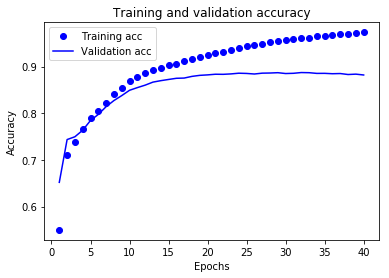

In [35]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()